In [6]:
import mysql
import mysql.connector
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt 
import requests 
import numpy as np 
import cv2 
from io import BytesIO
import os
import glob
import joblib

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet50_Weights
import  torch.nn.functional as F

import MeCab
from konlpy.tag import Okt

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

import sys
sys.path.append('/Users/anhyojun/WorkSpace/KDT2/MyModule')
from KDTModule import *

In [2]:
torch.manual_seed(1)

In [4]:
# # csv -> DataFrame 변환
# df = pd.read_csv('movieDF.csv')
# df.info()

In [13]:
conn = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = 'signcity114',
    database = 'MyDB'
)

cursor = conn.cursor()

query = """
SELECT * FROM movie
where genre not like '%, %';"""

df = pd.read_sql(query, conn)
df

/var/folders/ld/7fj1069x6q7fr5894rwywdk40000gn/T/ipykernel_1086/2003261361.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,id,ko_name,en_name,year,country,grade,genre,runtime,release_date,audience,director,story,poster_link
0,7,아기공룡 둘리: 얼음별 대모험 리마스터링,Little Dinosaur Doolie,1996.0,한국,전체 관람가,애니메이션,84.0,2023-05-24,126874.0,김수정 임경원,아기공룡 둘리는 1억 년 전 거대한 빙산 조각에 갇혀 엄마와 헤어지게 되고 그 안에...,https://image.cine21.com/resize/cine21/poster/...
1,11,마이클 콜린스,Michael Collins,1996.0,"영국,아일랜드,미국",15세이상관람가,드라마,132.0,1997-01-18,33719.0,닐 조던,12세기 이래로 영국의 통치를 받아 온 아일랜드의 독립군은 6개월간의 투쟁 끝에 영...,https://image.cine21.com/resize/cine21/poster/...
2,12,트레인스포팅,Trainspotting,1996.0,영국,청소년 관람불가,드라마,91.0,1997-02-22,139322.0,대니 보일,마크 렌턴은 에딘버러의 거리에서 두 명의 상점 감시자들에게 쫓기고 있다. 자켓에 넣...,https://image.cine21.com/resize/IMGDB/poster/2...
3,15,동궁서궁,East Palace West Palace,1996.0,중국,청소년 관람불가,드라마,90.0,None,NaN,장유안,민감한 젊은 작가 아란은 어느날 동성애자들이 종종 찾는 북경의 국립공원을 거닐고 있...,https://image.cine21.com/resize/cine21/poster/...
4,18,시간은 오래 지속된다,Time Lasts,1996.0,한국,15세이상관람가,드라마,90.0,None,NaN,김응수,하얗게 눈이 쌓인 모스크바 근교의 별장. 새해를 앞두고 한무리의 한국인들이 모인다....,https://image.cine21.com/resize/cine21/poster/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24063,61818,에드워드 호퍼,Hopper - An American Love Story,2023.0,영국,None,다큐멘터리,94.0,None,NaN,필 그랍스키,예술가들이 가장 사랑하는 예술가에드워드 호퍼의 숨겨진 이야기가 온다! 알프레드 히치...,None
24064,61820,4분 44초,,2022.0,한국,12세이상관람가,공포,44.0,2024-11-01,NaN,박종균,[입주민 여러분께 협조 요청 드립니다] 북촌아파트 경비실입니다. 최근 우리 단지 내...,https://image.cine21.com/resize/cine21/poster/...
24065,61824,춘천대첩 72시간,,2024.0,한국,전체 관람가,다큐멘터리,94.0,2024-11-14,NaN,장이레 최동호,반드시 기억해야 할 승리가 온다! 역사에는 가정이 없다고 하지만 만약 그날 춘천에서...,https://image.cine21.com/resize/cine21/poster/...
24066,61825,위대한 부재,Great Absence,2024.0,일본,15세이상관람가,드라마,133.0,2024-11-06,NaN,치카우라 케이,인질 없는 인질극을 벌인 아버지VS 아버지란 이름의 수수께끼를 풀어야 하는 아들 “...,None


In [4]:
# 장르 종류 리스트화
genre = df['genre']

genre_columns = set()
for i in genre:
    split_list = i.split(', ')
    for j in split_list:
        genre_columns.add(j)

genre_list = list(genre_columns)

# 장르 종류 개수
print(len(genre_list))
print(genre_list)

35
['어드벤처', '퀴어', '서스펜스', '서부', '애니메이션', '코미디', '스파이', '자연재해', '뮤지컬', '가족', '드라마', '실화', '전쟁', '블록버스터', '판타지', '액션', '3D', '미스터리', '뮤직', '스포츠', '추리', '멜로·로맨스', '다큐멘터리', '무협', '역사·서사', '느와르', '범죄', '시대극', '모험', '공포', 'SF', '전기', '실험영화', '옴니버스', '스릴러']


In [5]:
# 다중 레이블 장르 원-핫 인코딩
total_one_hot_list = []
for i in genre:
    split_list = i.split(', ')
    one_hot_list = [0] * len(genre_list)
    for j in split_list:
        for index, value in enumerate(genre_list):
            if j == value:
                one_hot_list[index] += 1
    total_one_hot_list.append(one_hot_list)

In [6]:
target_one_hot = pd.DataFrame(total_one_hot_list, columns=genre_list)
target_one_hot

,어드벤처,퀴어,서스펜스,서부,애니메이션,코미디,스파이,자연재해,뮤지컬,가족,...,느와르,범죄,시대극,모험,공포,SF,전기,실험영화,옴니버스,스릴러
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9898,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9899,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# 장르별 빈도수 확인
idx = target_one_hot.sum(axis=0).index
freq = target_one_hot.sum(axis=0).values
sorted(zip(idx, freq), key= lambda x : x[1])

[('스파이', 1),
 ('실험영화', 1),
 ('자연재해', 2),
 ('퀴어', 3),
 ('모험', 4),
 ('서스펜스', 6),
 ('추리', 7),
 ('실화', 12),
 ('전기', 16),
 ('역사·서사', 22),
 ('스포츠', 25),
 ('시대극', 27),
 ('옴니버스', 27),
 ('서부', 32),
 ('3D', 34),
 ('느와르', 47),
 ('무협', 73),
 ('뮤직', 116),
 ('뮤지컬', 118),
 ('블록버스터', 133),
 ('어드벤처', 159),
 ('전쟁', 173),
 ('가족', 217),
 ('SF', 473),
 ('미스터리', 478),
 ('판타지', 489),
 ('공포', 534),
 ('다큐멘터리', 546),
 ('스릴러', 851),
 ('애니메이션', 900),
 ('범죄', 1326),
 ('멜로·로맨스', 1619),
 ('액션', 1882),
 ('코미디', 1883),
 ('드라마', 4549)]

빈도수가 너무 적은 장르들이 많다

(드라마, 멜로·로맨스, 가족)
(코미디, )
(액션, 범죄, 스릴러)
(다큐멘터리, )
(공포, 미스터리, )
(판타지, )
(SF, )
()

In [8]:
# 빈도수가 적은 장르 '그 외'로 통합
cols = ['스파이', '실험영화', '자연재해', '퀴어', '모험', '서스펜스', '추리', '실화',
        '전기', '역사·서사', '스포츠', '시대극', '옴니버스', '서부', '3D', '느와르',
        '무협']
target_one_hot['그 외'] = [1 if i >= 1 else 0 for i in target_one_hot[cols].sum(axis=1)]
target_one_hot_scaled = target_one_hot.drop(cols, axis=1)
target_one_hot_scaled['id'] = df['id']
target_one_hot_scaled

,코미디,드라마,판타지,액션,미스터리,멜로·로맨스,다큐멘터리,범죄,공포,SF,스릴러,그 외,id
0,0,1,0,1,0,0,0,1,0,0,0,0,1
1,0,1,0,1,0,0,0,1,0,0,0,0,2
2,1,0,0,0,0,1,0,0,0,0,0,0,3
3,0,1,0,0,0,1,0,0,0,0,0,0,4
4,0,0,0,0,0,1,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9896,0,0,0,0,0,0,0,0,0,0,0,1,61787
9897,0,0,0,0,0,0,0,0,0,0,0,1,61796
9898,0,0,0,0,0,0,1,0,0,0,0,0,61797
9899,0,0,0,0,0,0,0,0,0,0,0,1,61804


In [9]:
target_one_hot_scaled[target_one_hot_scaled['드라마'] == 2]

,코미디,드라마,판타지,액션,미스터리,멜로·로맨스,다큐멘터리,범죄,공포,SF,스릴러,그 외,id
2888,0,2,0,0,0,0,0,0,0,0,0,0,12094
5567,0,2,0,0,0,0,0,0,0,0,0,0,38643
6721,0,2,0,0,0,0,0,0,0,0,0,0,46577


아놔... 빈도가 2 이상인 장르가 있다... 홈페이지를 보니 실수를 한 것 같다... (드라마, 드라마) 이런 식으로 적어놨는데 제기랄...

In [ ]:
# 빈도수가 적은 장르 '그 외'로 통합
cols = ['뮤지컬', '전쟁', '뮤직', '3D', '스포츠', '어드벤처', '스파이', '블록버스터', '추리',
        '가족', '자연재해', '퀴어', '실험영화', '느와르', '실화', '옴니버스', '시대극', '전기',
        '서스펜스', '무협', '모험', '모험', '역사·서사', '서부', '애니메이션']
target_one_hot['그 외'] = [1 if i >= 1 else 0 for i in target_one_hot[cols].sum(axis=1)]
target_one_hot_scaled = target_one_hot.drop(cols, axis=1)
target_one_hot_scaled['id'] = df['id']
target_one_hot_scaled

In [10]:
for i in target_one_hot_scaled.columns[:-1]:
    target_one_hot_scaled[i] = [1 if i >= 1 else 0 for i in target_one_hot_scaled[i]]

for i in target_one_hot_scaled.columns[:-1]:
    print(target_one_hot_scaled[i].value_counts())

코미디
0    8019
1    1882
Name: count, dtype: int64
드라마
0    5355
1    4546
Name: count, dtype: int64
판타지
0    9412
1     489
Name: count, dtype: int64
액션
0    8020
1    1881
Name: count, dtype: int64
미스터리
0    9423
1     478
Name: count, dtype: int64
멜로·로맨스
0    8282
1    1619
Name: count, dtype: int64
다큐멘터리
0    9355
1     546
Name: count, dtype: int64
범죄
0    8575
1    1326
Name: count, dtype: int64
공포
0    9367
1     534
Name: count, dtype: int64
SF
0    9428
1     473
Name: count, dtype: int64
스릴러
0    9050
1     851
Name: count, dtype: int64
그 외
0    8029
1    1872
Name: count, dtype: int64


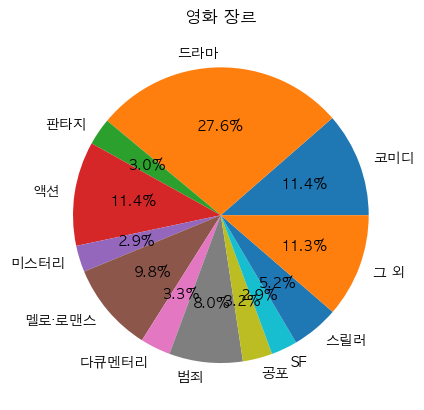

In [11]:
value = target_one_hot_scaled.drop('id', axis=1).sum(axis=0)
plt.rc('font', family='AppleGothic')
plt.pie(value, labels=value.index, autopct='%.1f%%')
plt.title('영화 장르')
plt.show()

드라마 장르가 너무 많다

In [12]:
# # 드라마 제외한 장르 선택 후 중강
no_drama = target_one_hot_scaled[target_one_hot_scaled['드라마'] == 0]
total_target = pd.concat([target_one_hot_scaled, no_drama, no_drama], axis=0).drop('id', axis=1)
total_target.sum(axis=0)
total_target

,코미디,드라마,판타지,액션,미스터리,멜로·로맨스,다큐멘터리,범죄,공포,SF,스릴러,그 외
0,0,1,0,1,0,0,0,1,0,0,0,0
1,0,1,0,1,0,0,0,1,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9896,0,0,0,0,0,0,0,0,0,0,0,1
9897,0,0,0,0,0,0,0,0,0,0,0,1
9898,0,0,0,0,0,0,1,0,0,0,0,0
9899,0,0,0,0,0,0,0,0,0,0,0,1


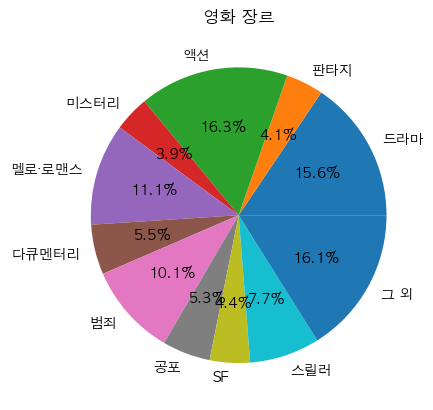

In [13]:
value = total_target.iloc[:,1:].sum(axis=0)
plt.rc('font', family='AppleGothic')
plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('영화 장르')
plt.show()

아직 불균형이 존재하긴 하지만 이전에 비해서는 개선되었다

In [14]:
# # 포스터 저장
# idx = 0
# poster_link = df['poster_link'][idx:]
# for index, link in enumerate(poster_link):
#     response = requests.get(link)
#     img = Image.open(BytesIO(response.content))
#     RGB_img = img.convert('RGB')
#     id = df['id'][index+idx]
#     safe_name = df['ko_name'][index+idx].replace('/', ' ')
#     RGB_img.save(f"/Users/anhyojun/WorkSpace/LocalData/영화 포스터/{id}_{safe_name}.jpg")

In [15]:
# # 이미지 증강
# no_drama_id = target_one_hot_scaled[target_one_hot_scaled['드라마'] == 0]['id']
# poster_path = '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/'

# flip = transforms.RandomHorizontalFlip(p=1)
# elastic = transforms.ElasticTransform()

# for id in no_drama_id.values:
#     name = df[df['id'] == id]['ko_name'].iloc[0].replace('/', ' ')
#     img = Image.open(f"{poster_path}{id}_{name}.jpg")
#     flip_img = flip(img)
#     elastic_img = elastic(img)
#     save_path1 = f'/Users/anhyojun/WorkSpace/LocalData/영화 포스터 반전/{id}_{name}_reverse.jpg'
#     save_path2 = f'/Users/anhyojun/WorkSpace/LocalData/영화 포스터 왜곡/{id}_{name}_elastic.jpg'
#     flip_img.save(save_path1)
#     elastic_img.save(save_path2)

In [16]:
# 이미지 폴더 경로
poster_path1 = '/Users/anhyojun/WorkSpace/LocalData/영화 포스터'
poster_path2 = '/Users/anhyojun/WorkSpace/LocalData/영화 포스터 반전'
poster_path3 = '/Users/anhyojun/WorkSpace/LocalData/영화 포스터 왜곡'

# 폴더 리스트
poster_paths = [poster_path1, poster_path2, poster_path3]

In [17]:
all_poster_path = []

for path in poster_paths:
    path_list = glob.glob(f"{path}/*.jpg")
    sorted_path = sorted(path_list, key=lambda x : int(x.split('_')[0].split('/')[-1]))
    all_poster_path.extend(sorted_path)

In [18]:
len(all_poster_path)

20611

In [19]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labelsDF, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.labels = np.array(labelsDF)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            input_tensor = self.transform(image)

        label_tensor = torch.tensor(label, dtype=torch.float)

        return input_tensor, label_tensor

In [20]:
train_path, test_path, train_label, test_label = train_test_split(all_poster_path, total_target,
                                                                  test_size = 0.2, random_state = 42)
train_path, valid_path, train_label, valid_label = train_test_split(train_path, train_label,
                                                                    test_size = 0.2, random_state = 42)
print(f"train_label.shape {train_label.shape}")
print(f"valid_label.shape {valid_label.shape}")
print(f"test_label.shape {test_label.shape}")

train_label.shape (13190, 12)
valid_label.shape (3298, 12)
test_label.shape (4123, 12)


In [21]:
# 이미지 전처리(transform) 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 정규화 값
])

trainDS = CustomImageDataset(train_path, train_label, transform)
validDS = CustomImageDataset(valid_path, valid_label, transform)
testDS = CustomImageDataset(test_path, test_label, transform)

trainDL = DataLoader(trainDS, batch_size=32, shuffle=True)
validDL = DataLoader(validDS, batch_size=32, shuffle=True)
testDL = DataLoader(testDS, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


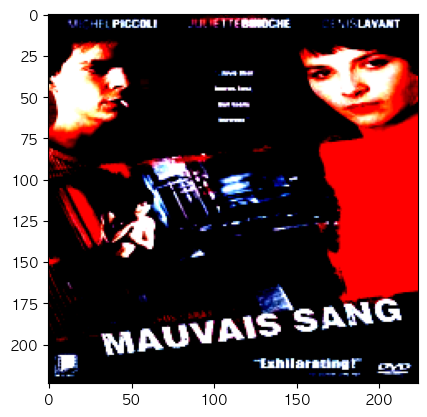

In [22]:
plt.imshow(trainDL.dataset[2][0].permute(1,2,0))
plt.show()

In [24]:
# 미리 학습된 ResNet 모델 불러오기 (weight 사용)
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.fc.parameters():
    param.requires_grad = True

# 마지막 레이어 (full connected layer) 교체
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 12))

In [25]:
# 마지막 레이어 (full connected layer) 교체
# num_features = model.fc.in_features # 2048
# model.fc = nn.Linear(num_features, 13)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 12)
)

In [26]:
# MPS 사용 여부 확인하기
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"device : {device}")

device : mps


In [28]:
# 훈련
EPOCH = 100
SAVE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/ResNet50'

# 옵티마이저를 모델 파라미터에 대해 초기화
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# optimizer = torch.optim.RAdam(model.parameters(), lr=0.005)


result = training(trainDL, validDL, model, model_type = 'multilabel', optimizer = optimizer, epoch = EPOCH,
                  endurance_cnt = 10, view_epoch = 1, num_classes = 12, SAVE_PATH = SAVE_PATH, MPS = True, device = device)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 0.3413, Test : 0.3038
[Score  : 1/100] Train : 0.2276, Test : 0.2390
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 0.2954, Test : 0.2928
[Score  : 2/100] Train : 0.3569, Test : 0.3608
[EPOCH] : 3에서 모델 저장 완료.
[Loss : 3/100] Train : 0.2844, Test : 0.2829
[Score  : 3/100] Train : 0.4033, Test : 0.4172
[EPOCH] : 4에서 모델 저장 완료.
[Loss : 4/100] Train : 0.2754, Test : 0.2785
[Score  : 4/100] Train : 0.4395, Test : 0.4301
[Loss : 5/100] Train : 0.2684, Test : 0.2846
[Score  : 5/100] Train : 0.4523, Test : 0.4091
[EPOCH] : 6에서 모델 저장 완료.
[Loss : 6/100] Train : 0.2607, Test : 0.2765
[Score  : 6/100] Train : 0.4796, Test : 0.4313
[EPOCH] : 7에서 모델 저장 완료.
[Loss : 7/100] Train : 0.2536, Test : 0.2721
[Score  : 7/100] Train : 0.4997, Test : 0.4636
[Loss : 8/100] Train : 0.2451, Test : 0.2737
[Score  : 8/100] Train : 0.5256, Test : 0.4696
[Loss : 9/100] Train : 0.2351, Test : 0.2781
[Score  : 9/100] Train : 0.5499, Test : 0.4886
[Loss : 10/100] Train : 0.22

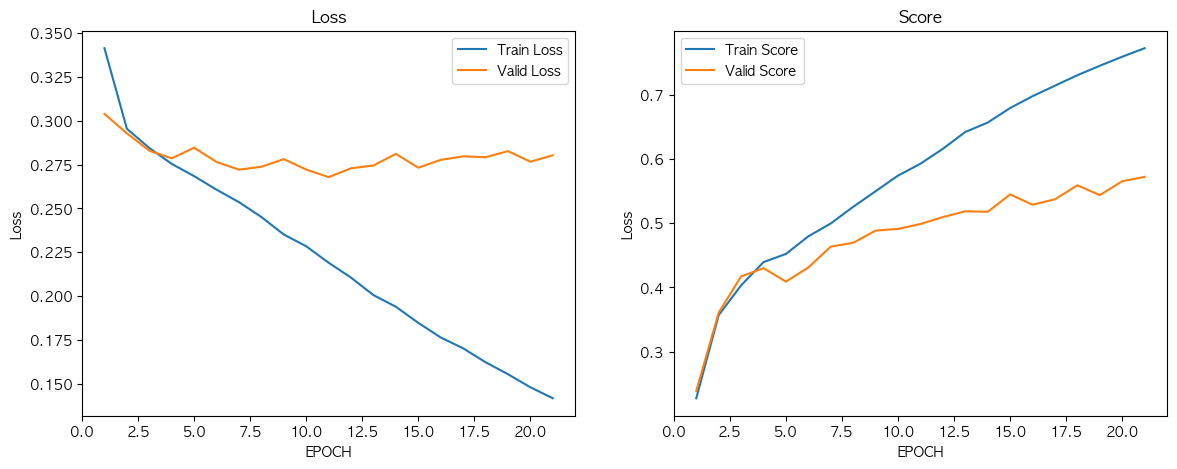

In [29]:
DrawPlot(result)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [30]:
model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.classifier.parameters():
    param.requires_grad = True

model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 12)
)

In [31]:
# 훈련
EPOCH = 100
SAVE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/EfficientNet'

# 옵티마이저를 모델 파라미터에 대해 초기화
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# optimizer = torch.optim.RAdam(model.parameters(), lr=0.005)

result = training(trainDL, validDL, model, model_type = 'multilabel', optimizer = optimizer, epoch = EPOCH,
                  endurance_cnt = 10, view_epoch = 1, num_classes = 12, SAVE_PATH = SAVE_PATH, MPS = True, device = device)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 0.3655, Test : 0.3166
[Score  : 1/100] Train : 0.2197, Test : 0.1795
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 0.2940, Test : 0.2847
[Score  : 2/100] Train : 0.3848, Test : 0.4528
[EPOCH] : 3에서 모델 저장 완료.
[Loss : 3/100] Train : 0.2569, Test : 0.2771
[Score  : 3/100] Train : 0.5057, Test : 0.4634
[Loss : 4/100] Train : 0.2187, Test : 0.2813
[Score  : 4/100] Train : 0.6099, Test : 0.5018
[Loss : 5/100] Train : 0.1804, Test : 0.2839
[Score  : 5/100] Train : 0.6956, Test : 0.5258
[Loss : 6/100] Train : 0.1461, Test : 0.3093
[Score  : 6/100] Train : 0.7671, Test : 0.5474
[Loss : 7/100] Train : 0.1190, Test : 0.3235
[Score  : 7/100] Train : 0.8130, Test : 0.5612
[Loss : 8/100] Train : 0.0950, Test : 0.3679
[Score  : 8/100] Train : 0.8561, Test : 0.5579
[Loss : 9/100] Train : 0.0793, Test : 0.3859
[Score  : 9/100] Train : 0.8810, Test : 0.5554
[Loss : 10/100] Train : 0.0703, Test : 0.4142
[Score  : 10/100] Train : 0.8967, Test : 0.5732
[Loss 

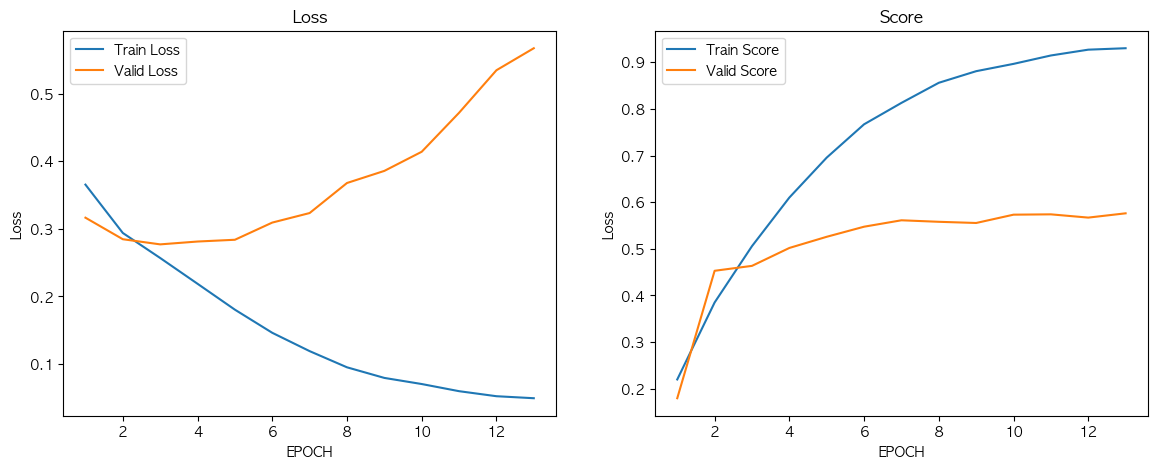

In [32]:
DrawPlot(result)
plt.show()

In [168]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.classifier.parameters():
    param.requires_grad = True

model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 1024),
    nn.BatchNorm1d(1024), # 배치 정규화
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 13)
)

In [169]:
# 훈련
EPOCH = 100
SAVE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/EfficientNet'

# 옵티마이저를 모델 파라미터에 대해 초기화 (weight_decay : L2 정규화)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0001)

# optimizer = torch.optim.RAdam(model.parameters(), lr=0.005)

result = training(trainDL, validDL, model, model_type = 'multilabel', optimizer = optimizer, epoch = EPOCH,
                  endurance_cnt = 10, view_epoch = 1, num_classes = 13, SAVE_PATH = SAVE_PATH, MPS = True, device = device)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 0.3301, Test : 0.2932
[Score  : 1/100] Train : 0.2446, Test : 0.3003
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 0.2887, Test : 0.2884
[Score  : 2/100] Train : 0.3295, Test : 0.2989
[EPOCH] : 3에서 모델 저장 완료.
[Loss : 3/100] Train : 0.2803, Test : 0.2847
[Score  : 3/100] Train : 0.3653, Test : 0.3969
[EPOCH] : 4에서 모델 저장 완료.
[Loss : 4/100] Train : 0.2727, Test : 0.2797
[Score  : 4/100] Train : 0.4030, Test : 0.4306
[EPOCH] : 5에서 모델 저장 완료.
[Loss : 5/100] Train : 0.2626, Test : 0.2786
[Score  : 5/100] Train : 0.4368, Test : 0.4151
[EPOCH] : 6에서 모델 저장 완료.
[Loss : 6/100] Train : 0.2532, Test : 0.2704
[Score  : 6/100] Train : 0.4723, Test : 0.4082
[EPOCH] : 7에서 모델 저장 완료.
[Loss : 7/100] Train : 0.2451, Test : 0.2692
[Score  : 7/100] Train : 0.4994, Test : 0.4527
[EPOCH] : 8에서 모델 저장 완료.
[Loss : 8/100] Train : 0.2385, Test : 0.2689
[Score  : 8/100] Train : 0.5200, Test : 0.4445
[Loss : 9/100] Train : 0.2326, Test : 0.2695
[Score  : 9/100] Train : 0.

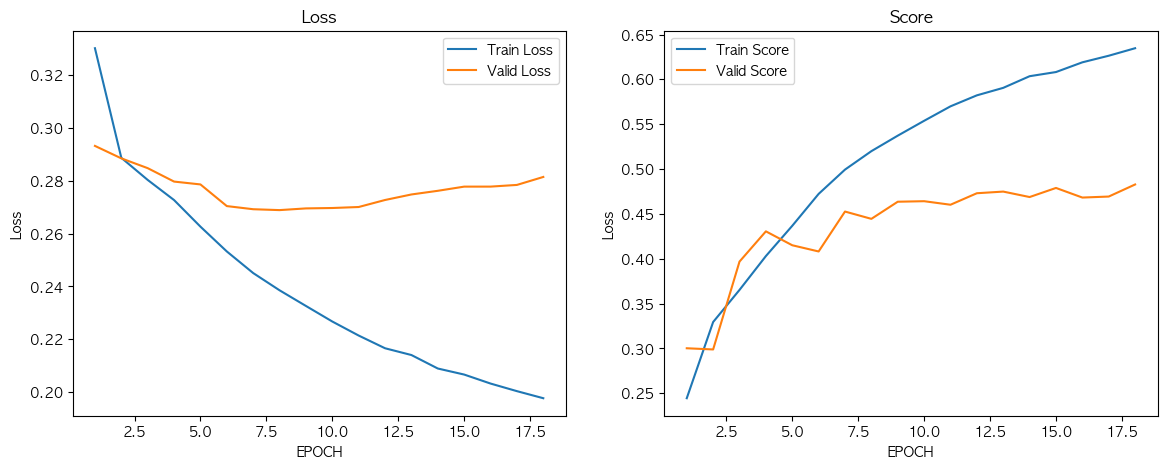

In [170]:
DrawPlot(result)
plt.show()